## Imports

In [208]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

## Read the data

In [143]:
project_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(project_dir, 'data', 'raw', 'customer_churn_dataset-training-master.csv')

In [144]:
df = pd.read_csv(data_dir)

In [145]:
df.head(10)

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
5,8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0
6,9.0,58.0,Female,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0
7,10.0,55.0,Female,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0
8,11.0,39.0,Male,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0
9,12.0,64.0,Female,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0


In [146]:
df.drop(columns='CustomerID', inplace=True)

In [147]:
print(df.isna().sum())

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64


In [148]:
df.dropna(inplace=True)

Convert data types

In [149]:
int_cols = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
for col in int_cols:
    df[col] = df[col].astype('int64')

categorical_cols = ['Gender', 'Subscription Type', 'Contract Length']
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Age                440832 non-null  int64   
 1   Gender             440832 non-null  category
 2   Tenure             440832 non-null  int64   
 3   Usage Frequency    440832 non-null  int64   
 4   Support Calls      440832 non-null  int64   
 5   Payment Delay      440832 non-null  int64   
 6   Subscription Type  440832 non-null  category
 7   Contract Length    440832 non-null  category
 8   Total Spend        440832 non-null  int64   
 9   Last Interaction   440832 non-null  int64   
 10  Churn              440832 non-null  int64   
dtypes: category(3), int64(8)
memory usage: 31.5 MB


In [151]:
df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.344771,14.480868,0.567107
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.722712,8.596208,0.495477
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


## Feature Engineering

In [152]:
df['Spend_per_Tenure'] = df['Total Spend'] / (df['Tenure'] + 1)  # Avoid division by zero
df['SupportCalls_per_Tenure'] = df['Support Calls'] / (df['Tenure'] + 1)
df['Usage_per_Tenure'] = df['Usage Frequency'] / (df['Tenure'] + 1)

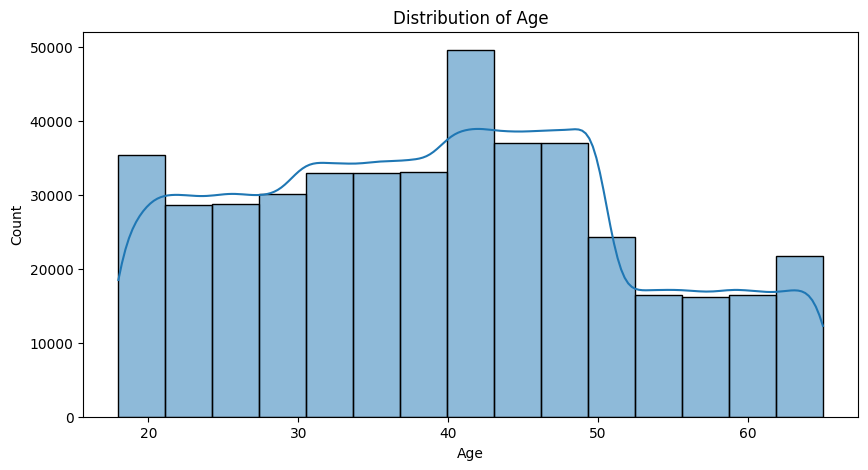

In [153]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Age'], bins=15, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()

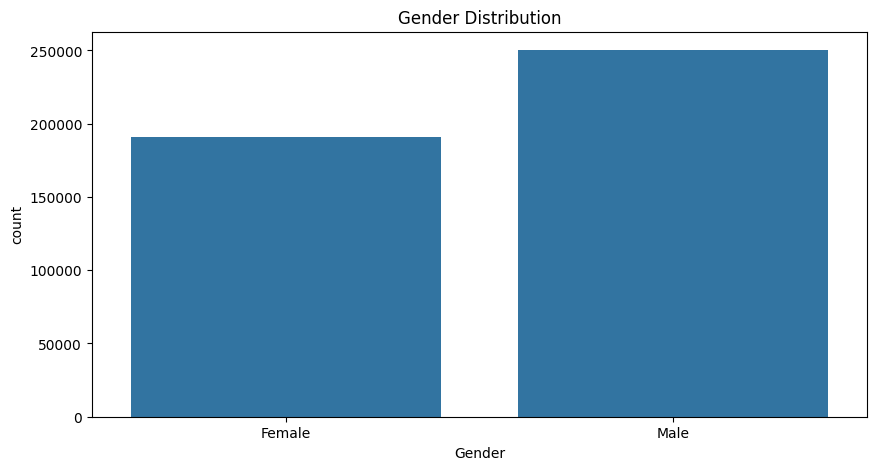

In [154]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

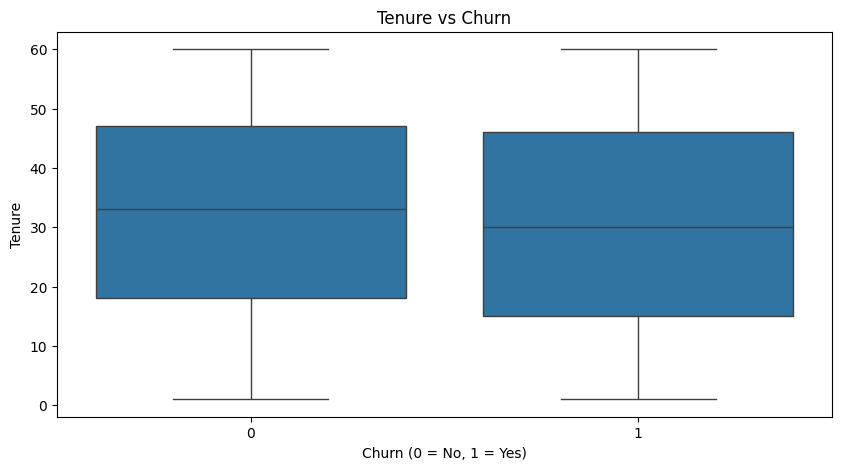

In [155]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Tenure', data=df)
plt.title('Tenure vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()

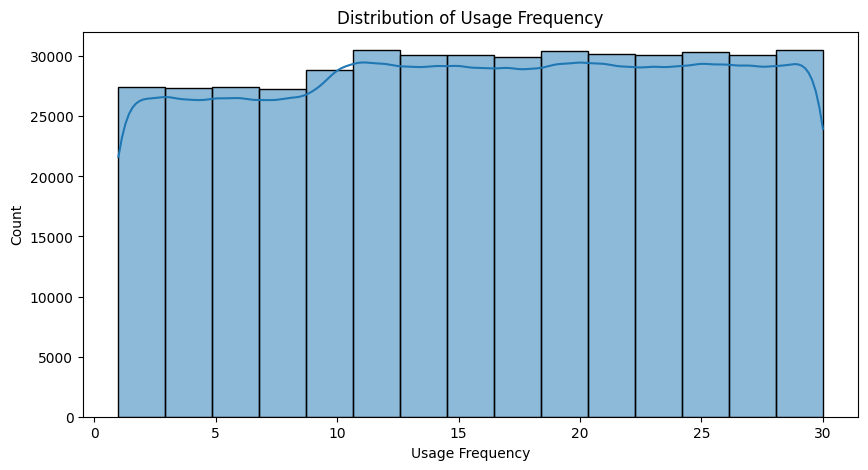

In [156]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Usage Frequency'], bins=15, kde=True)
plt.title('Distribution of Usage Frequency')
plt.xlabel('Usage Frequency')
plt.show()

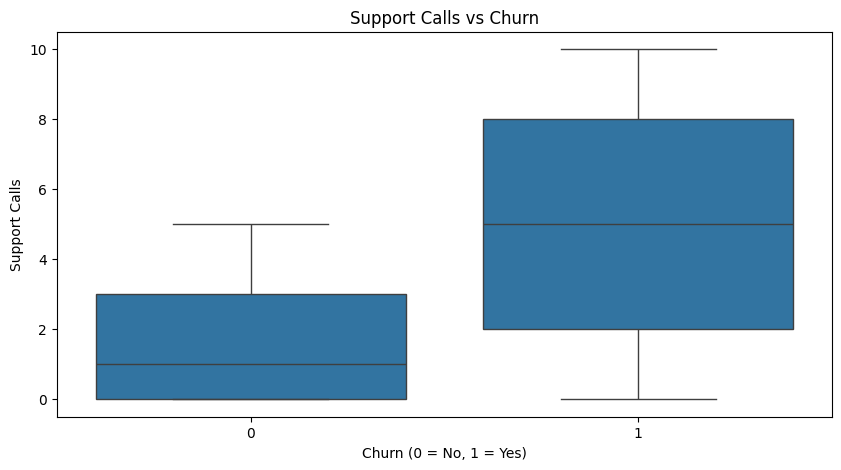

In [157]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Support Calls', data=df)
plt.title('Support Calls vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()

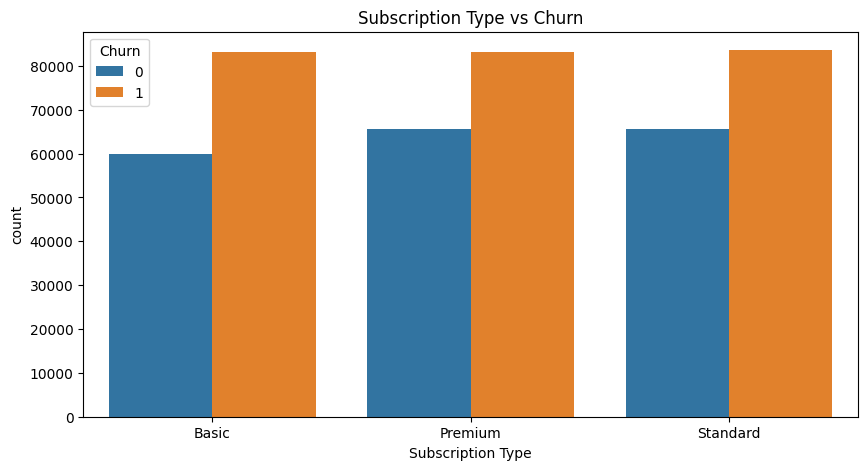

In [158]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Subscription Type', hue='Churn', data=df)
plt.title('Subscription Type vs Churn')
plt.show()

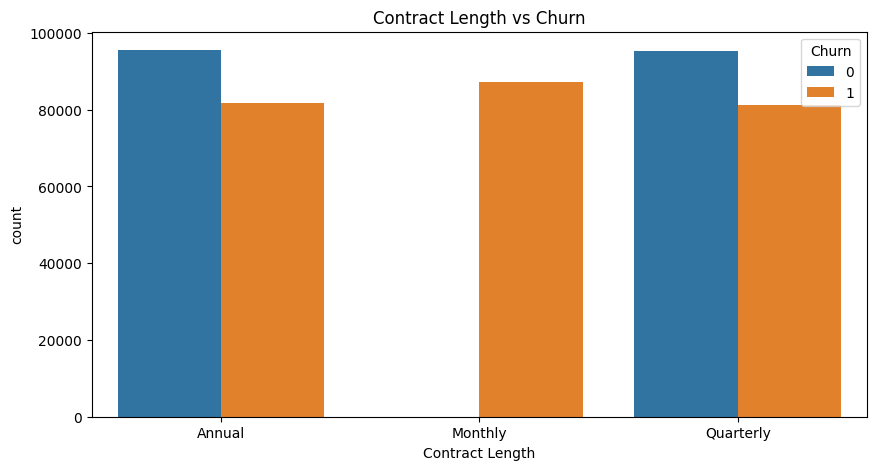

In [159]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Contract Length', hue='Churn', data=df)
plt.title('Contract Length vs Churn')
plt.show()

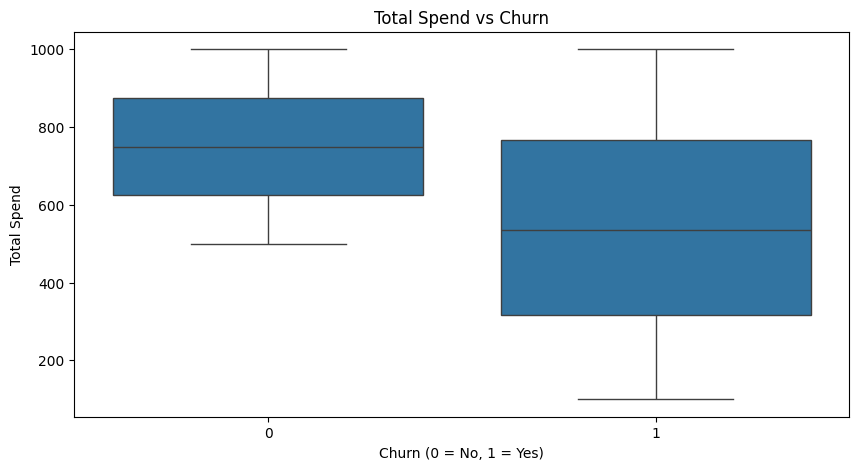

In [160]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Churn', y='Total Spend', data=df)
plt.title('Total Spend vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()

Encode categoric variables

In [161]:
df['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)

In [162]:
df = pd.get_dummies(data=df , columns=['Subscription Type', 'Contract Length'])

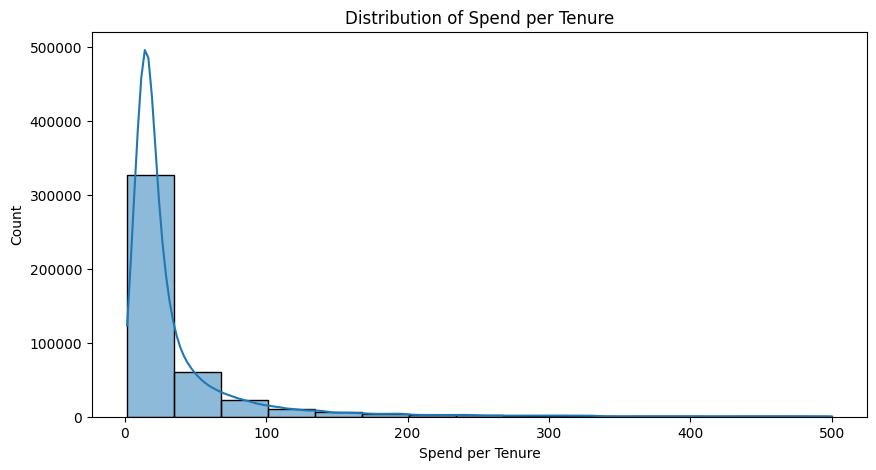

In [163]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Spend_per_Tenure'], bins=15, kde=True)
plt.title('Distribution of Spend per Tenure')
plt.xlabel('Spend per Tenure')
plt.show()

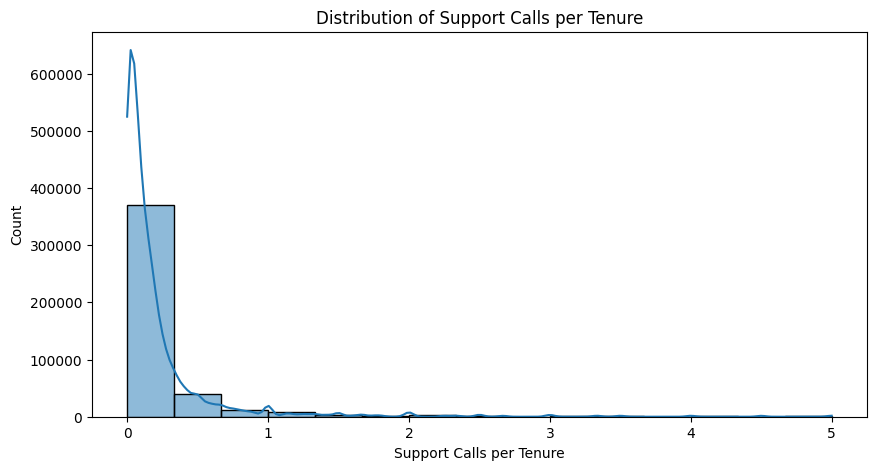

In [164]:
plt.figure(figsize=(10, 5))
sns.histplot(df['SupportCalls_per_Tenure'], bins=15, kde=True)
plt.title('Distribution of Support Calls per Tenure')
plt.xlabel('Support Calls per Tenure')
plt.show()

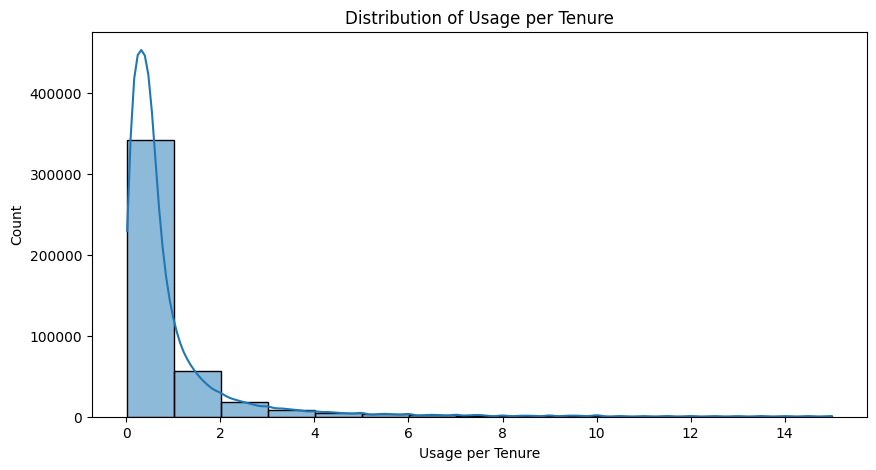

In [165]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Usage_per_Tenure'], bins=15, kde=True)
plt.title('Distribution of Usage per Tenure')
plt.xlabel('Usage per Tenure')
plt.show()

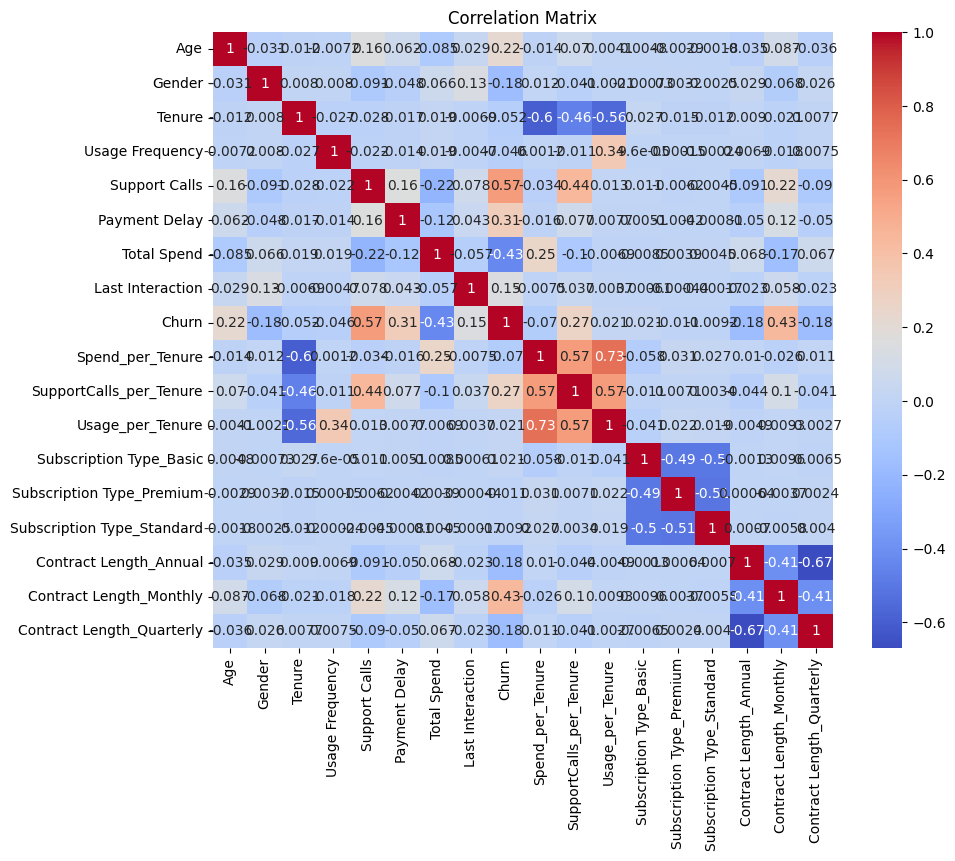

In [166]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Prepare the data

In [167]:
threshold = 0.03

correlation_matrix = df.corr()
high_corr_features = correlation_matrix.index[abs(correlation_matrix["Churn"]) > threshold].tolist()
high_corr_features.remove("Churn")
print(high_corr_features)

['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Spend_per_Tenure', 'SupportCalls_per_Tenure', 'Contract Length_Annual', 'Contract Length_Monthly', 'Contract Length_Quarterly']


In [168]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [169]:
X = X[high_corr_features]

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Scale the data

In [172]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Build Deep Learning Model

Create TensorBoard logger

In [173]:
logger1 = TensorBoard(
    log_dir=os.path.join(project_dir, 'models', 'logs', 'model1'),
    histogram_freq=5,
    write_graph=True,
    write_images=True
)

Build the model

In [ ]:
model1 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

c:\Users\uif93590\Desktop\SoftwareProjects\customer-churn-analysis\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [175]:
history1 = model1.fit(X_train_scaled, y_train, epochs=8, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[logger1])

Epoch 1/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.9324 - loss: 0.1613 - val_accuracy: 0.9898 - val_loss: 0.0350
Epoch 2/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - accuracy: 0.9857 - loss: 0.0466 - val_accuracy: 0.9907 - val_loss: 0.0330
Epoch 3/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 63s 6ms/step - accuracy: 0.9872 - loss: 0.0423 - val_accuracy: 0.9859 - val_loss: 0.0417
Epoch 4/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.9881 - loss: 0.0391 - val_accuracy: 0.9923 - val_loss: 0.0265
Epoch 5/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - accuracy: 0.9892 - loss: 0.0362 - val_accuracy: 0.9915 - val_loss: 0.0290
Epoch 6/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - accuracy: 0.9894 - loss: 0.0354 - val_accuracy: 0.9913 - val_loss: 0.0297
Epoch 7/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - accuracy: 0.9903 - loss: 0.0328 - val_accuracy: 0.9933 - val_loss: 0.0242
Epoch 8/8
11021/11021 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - accuracy: 0.9900 -

Save the model

In [176]:
model1_path = os.path.join(project_dir, 'models', 'model1.keras')

In [177]:
model1.save(model1_path)

Load the model

In [178]:
# model1 = load_model(model1_path)

Predict

In [179]:
y_pred_prob1 = model1.predict(X_test_scaled)
y_pred1 = (y_pred_prob1 > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


Plot Training & Validation Accuracy

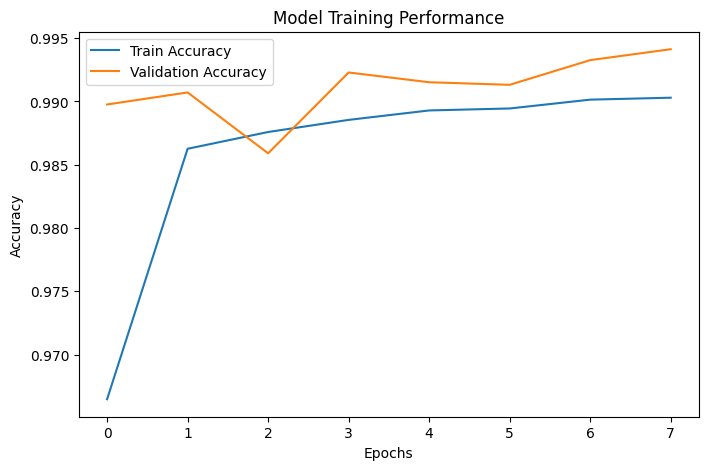

In [180]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Training Performance')
plt.legend()
plt.show()

Model1 Performance

In [181]:
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"\nANN Model Accuracy: {accuracy1:.4f}")
print(classification_report(y_test, y_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred1))


ANN Model Accuracy: 0.9941
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38063
           1       1.00      0.99      0.99     50104

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

Confusion Matrix:
 [[38054     9]
 [  509 49595]]


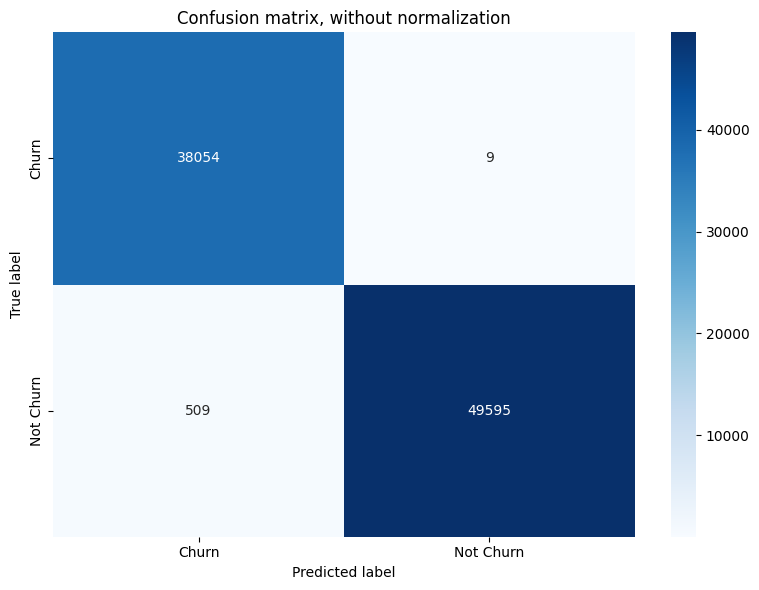

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=['Churn', 'No Churn'], yticklabels=['Churn', 'No Churn'])
plt.title('Confusion matrix, without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### Model2 with Weighted Binary Cross-Entropy

Define Weighted Binary Cross-Entropy loss

In [191]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

In [192]:
def weighted_binary_crossentropy(y_true, y_pred):
    weight_for_0 = 0.75
    weight_for_1 = 1.25

    bce = K.binary_crossentropy(y_true, y_pred)
    weights = y_true * weight_for_1 + (1 - y_true) * weight_for_0
    return K.mean(weights * bce)

Try adding batch normalization and more neurons in hidden layers.

In [193]:
model2 = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [194]:
model2.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [195]:
logger2 = TensorBoard(
    log_dir=os.path.join(project_dir, 'models', 'logs', 'model2'),
    histogram_freq=5,
    write_graph=True,
    write_images=True
)

In [196]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(1.1542351246972573), 1: np.float64(0.8821256159483729)}


In [197]:
history2 = model2.fit(
    X_train_scaled, y_train, 
    epochs=50,                  
    batch_size=64, 
    validation_data=(X_test_scaled, y_test), 
    class_weight=class_weight_dict,
    callbacks=[logger2, early_stopping]
)

Epoch 1/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9310 - loss: 0.1645 - val_accuracy: 0.9877 - val_loss: 0.0458
Epoch 2/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9783 - loss: 0.0667 - val_accuracy: 0.9851 - val_loss: 0.0416
Epoch 3/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9829 - loss: 0.0557 - val_accuracy: 0.9882 - val_loss: 0.0363
Epoch 4/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9846 - loss: 0.0507 - val_accuracy: 0.9827 - val_loss: 0.0451
Epoch 5/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9849 - loss: 0.0492 - val_accuracy: 0.9940 - val_loss: 0.0246
Epoch 6/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9860 - loss: 0.0458 - val_accuracy: 0.9926 - val_loss: 0.0275
Epoch 7/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9874 - loss: 0.0425 - val_accuracy: 0.9936 - val_loss: 0.0263
Epoch 8/50
5511/5511 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9872 - loss: 0

In [198]:
y_pred_prob2 = model2.predict(X_test_scaled)
y_pred2 = (y_pred_prob2 > 0.5).astype("int32")  # Convert probabilities to binary (0 or 1)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [199]:
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"\nANN Model Accuracy: {accuracy2:.4f}")
print(classification_report(y_test, y_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred2))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob2):.4f}")


ANN Model Accuracy: 0.9940
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     38063
           1       1.00      0.99      0.99     50104

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167

Confusion Matrix:
 [[38022    41]
 [  485 49619]]
AUC-ROC Score: 0.9994


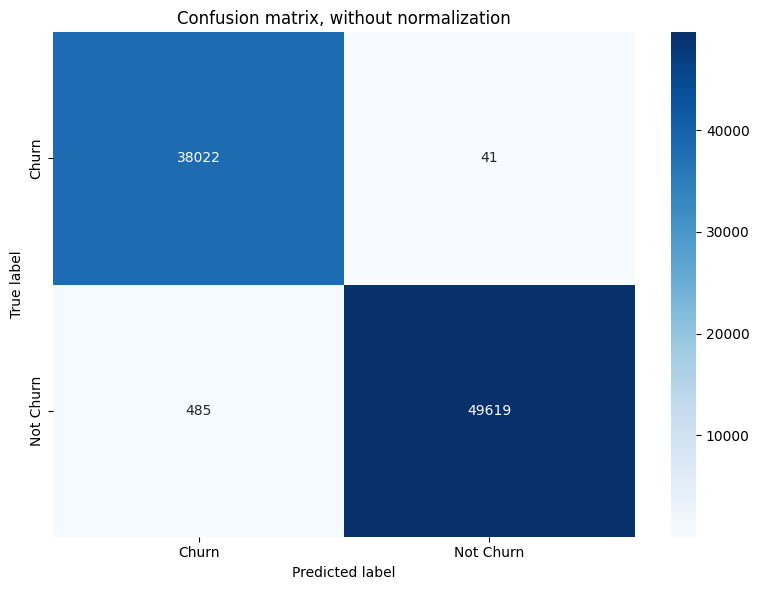

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=['Churn', 'No Churn'], yticklabels=['Churn', 'No Churn'])
plt.title('Confusion matrix, without normalization')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## XGBoost Model

In [202]:
model3 = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss',
    learning_rate=0.1, 
    n_estimators=100, 
    max_depth=6, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    random_state=42
)

In [203]:
model3.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [204]:
y_pred_prob3 = model3.predict_proba(X_test_scaled)[:, 1]
y_pred3 = (y_pred_prob3 > 0.5).astype("int32")

In [205]:
print("\nXGBoost Model Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred3))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob3):.4f}")


XGBoost Model Accuracy: 0.9989451835720848
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38063
           1       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167

Confusion Matrix:
 [[38063     0]
 [   93 50011]]
AUC-ROC Score: 0.9999


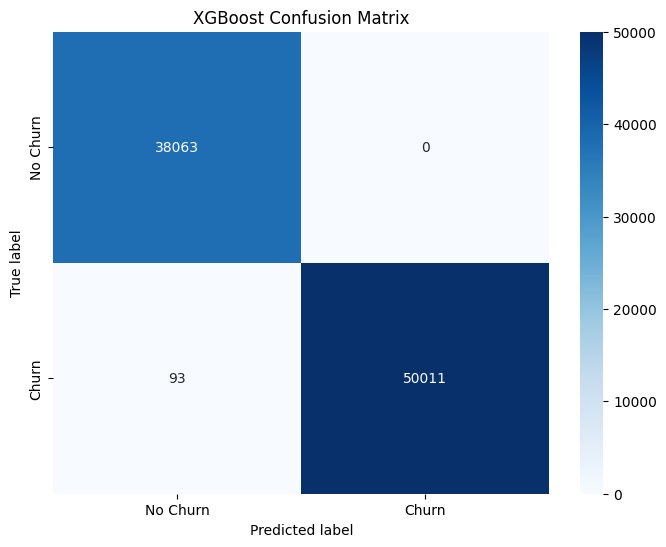

In [206]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred3), annot=True, fmt='d', cmap="Blues",
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("XGBoost Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

## Logistic regression

In [209]:
model4 = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

In [210]:
model4.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [211]:
y_pred_prob4 = model4.predict_proba(X_test_scaled)[:, 1]
y_pred4 = (y_pred_prob4 > 0.5).astype("int32")

In [212]:
print("\nLogistic Regression Model Accuracy:", accuracy_score(y_test, y_pred4))
print(classification_report(y_test, y_pred4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred4))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_prob4):.4f}")


Logistic Regression Model Accuracy: 0.896457858382388
              precision    recall  f1-score   support

           0       0.86      0.91      0.88     38063
           1       0.93      0.89      0.91     50104

    accuracy                           0.90     88167
   macro avg       0.89      0.90      0.90     88167
weighted avg       0.90      0.90      0.90     88167

Confusion Matrix:
 [[34563  3500]
 [ 5629 44475]]
AUC-ROC Score: 0.9596


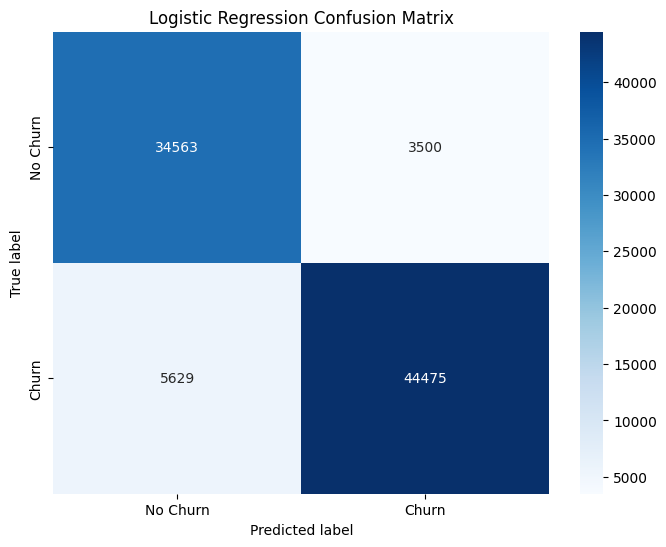

In [214]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred4), annot=True, fmt='d', cmap="Blues",
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()